In [10]:
import os
import random
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [11]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [12]:
import re
import numpy as np
import pandas as pd

CSV_PATH = "RelayMeasurementDataset.csv"  # numeric version with measurements + label

df = pd.read_csv(CSV_PATH)
assert 'label' in df.columns, "CSV must contain a 'label' column."
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Identify measurement columns (everything except 'label'), preserve order
measure_cols = [c for c in df.columns if c != 'label']

# Define semantic channel names and expected flattened order: (t0..t31) × [A_in, B_in, C_in, A_out, B_out, C_out]
channels = ["PhaseA_In", "PhaseB_In", "PhaseC_In", "PhaseA_Out", "PhaseB_Out", "PhaseC_Out"]
T = 32
expected_names = [f"t{t}_{ch}" for t in range(T) for ch in channels]  # 32*6 = 192

# If columns are generic (e.g., feature_0..feature_191), rename to semantic measurement names
if len(measure_cols) == 192 and all(re.fullmatch(r"feature_\d+", c) for c in measure_cols):
    rename_map = {f"feature_{i}": expected_names[i] for i in range(192)}
    df = df.rename(columns=rename_map)
    measure_cols = expected_names  # update to the new semantic names

print("Dataset shape:", df.shape)
print("Number of measurement columns:", len(measure_cols))
print("First 10 measurement columns:", measure_cols[:10])

# Show a tidy (32 × 6) view for the first sample to verify ordering
first_vec = df.loc[0, measure_cols].to_numpy(dtype=float)  # shape (192,)
M = first_vec.reshape(T, 6)  # (time, channels)
tidy_preview = pd.DataFrame(M, columns=channels, index=[f"t{t}" for t in range(T)])
print("\nPreview of one sample reshaped to (32 time steps × 6 channels):")
display(tidy_preview.head(8))  # first 8 time steps

Dataset shape: (53496, 193)
Number of measurement columns: 192
First 10 measurement columns: ['t0_PhaseA_In', 't0_PhaseB_In', 't0_PhaseC_In', 't0_PhaseA_Out', 't0_PhaseB_Out', 't0_PhaseC_Out', 't1_PhaseA_In', 't1_PhaseB_In', 't1_PhaseC_In', 't1_PhaseA_Out']

Preview of one sample reshaped to (32 time steps × 6 channels):


,PhaseA_In,PhaseB_In,PhaseC_In,PhaseA_Out,PhaseB_Out,PhaseC_Out
t0,0.429360,0.682497,0.276602,0.515688,0.280196,0.488571
t1,0.404175,0.676488,0.378008,0.517234,0.317524,0.376049
t2,0.384278,0.660755,0.486154,0.517846,0.364931,0.270320
t3,0.370767,0.636157,0.595091,0.517479,0.419840,0.177224
t4,0.364404,0.604014,0.698782,0.516168,0.479192,0.101935
t5,0.365597,0.566103,0.791395,0.513967,0.539717,0.048885
t6,0.374206,0.524579,0.867859,0.511006,0.598020,0.020675
t7,0.389752,0.481714,0.924013,0.507459,0.650902,0.018950


In [13]:
# Cell 5 — Stratified train/val split + scale measurements

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# X = relay measurements, y = labels
X = df[measure_cols].to_numpy(dtype=np.float32)
y = df['label'].to_numpy(dtype=np.int64)

# stratified split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# standardize measurements using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

print("Train shape:", X_train.shape, " | Val shape:", X_val.shape)
print("Train label counts:", np.bincount(y_train))
print("Val   label counts:", np.bincount(y_val))


Train shape: (42796, 192)  | Val shape: (10700, 192)
Train label counts: [39810  2986]
Val   label counts: [9954  746]


In [14]:
# Cell 6 — Build PyTorch datasets and loaders

import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long)
)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=0)

len(train_ds), len(val_ds)


Device: cuda


(42796, 10700)

In [15]:
# Cell 7 — Convert 32×6 measurements into descriptive text strings (per row)

feature_descriptions = [
    "Transformer Differential Relay's current measurement vector of phase A in transformer input side:",
    "Transformer Differential Relay's current measurement vector of phase B in transformer input side:",
    "Transformer Differential Relay's current measurement vector of phase C in transformer input side:",
    "Transformer Differential Relay's current measurement vector of phase A in transformer output side:",
    "Transformer Differential Relay's current measurement vector of phase B in transformer output side:",
    "Transformer Differential Relay's current measurement vector of phase C in transformer output side:"
]

def row_to_text(row_vals, T=32, channels=None, descs=None, decimals=2):
    """
    row_vals: shape (192,) flattened as (t0..t31) × 6 channels (A_in,B_in,C_in,A_out,B_out,C_out)
    returns a descriptive string like the original pipeline used.
    """
    assert row_vals.shape[0] == T * 6
    m = row_vals.reshape(T, 6)  # (time, channels)
    parts = []
    for ch_idx in range(6):
        vec = m[:, ch_idx]
        values_str = " ".join(f"{v:.{decimals}f}" for v in vec)
        parts.append(f"{descs[ch_idx]} [{values_str}]")
    return " ".join(parts)

# Build text column for the whole dataframe
texts = []
for i in range(len(df)):
    row = df.loc[i, measure_cols].to_numpy(dtype=float)
    texts.append(row_to_text(row, T=T, channels=channels, descs=feature_descriptions, decimals=2))

df_text = pd.DataFrame({"text": texts, "label": df["label"].astype(int).values})
print("Built text dataset shape:", df_text.shape)
df_text.head(2)


Built text dataset shape: (53496, 2)


,text,label
0,Transformer Differential Relay's current measu...,0
1,Transformer Differential Relay's current measu...,0


In [16]:
from sklearn.model_selection import train_test_split

SEED = 42
train_df, val_df = train_test_split(
    df_text, test_size=0.2, random_state=SEED, stratify=df_text["label"]
)

print("Train size:", train_df.shape, " | Val size:", val_df.shape)
print("Train label ratio:", train_df['label'].value_counts(normalize=True).sort_index().to_dict())
print("Val   label ratio:", val_df['label'].value_counts(normalize=True).sort_index().to_dict())


Train size: (42796, 2)  | Val size: (10700, 2)
Train label ratio: {0: 0.9302271240302832, 1: 0.06977287596971679}
Val   label ratio: {0: 0.9302803738317758, 1: 0.0697196261682243}


In [17]:
from transformers import DistilBertTokenizer

MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 512

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def encode_texts(texts):
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH
    )

train_encodings = encode_texts(train_df["text"])
val_encodings   = encode_texts(val_df["text"])
y_train = train_df["label"].to_numpy()
y_val   = val_df["label"].to_numpy()


In [18]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, y_train)
val_dataset   = TextDataset(val_encodings, y_val)

len(train_dataset), len(val_dataset)


(42796, 10700)

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


In [20]:
# Cell — Robust TrainingArguments + Trainer (handles old/new Transformers)

import inspect
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# Desired (new API) args
desired_args = dict(
    output_dir="./results_distilbert_main_from_numeric",
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=1000,
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none",
    seed=SEED,
)

# Filter to supported TrainingArguments kwargs
ta_sig = inspect.signature(TrainingArguments.__init__)
ta_supported = set(ta_sig.parameters.keys())
ta_args = {k: v for k, v in desired_args.items() if k in ta_supported}

# Legacy fallbacks if new keys aren't supported
use_early_stopping = True
if "evaluation_strategy" not in ta_supported:
    # old API fallbacks
    if "do_eval" in ta_supported:
        ta_args["do_eval"] = True
    if "evaluate_during_training" in ta_supported:
        ta_args["evaluate_during_training"] = True
    # remove newer keys that old versions won't accept
    for k in ("load_best_model_at_end", "metric_for_best_model", "greater_is_better", "report_to"):
        ta_args.pop(k, None)
    # can't safely use EarlyStopping without metric_for_best_model
    use_early_stopping = False

# If metric_for_best_model isn't accepted, disable early stopping safely
if "metric_for_best_model" not in ta_supported:
    ta_args.pop("load_best_model_at_end", None)
    use_early_stopping = False

training_args = TrainingArguments(**ta_args)

# Build Trainer kwargs (filter in case older Trainer lacks some)
tr_sig = inspect.signature(Trainer.__init__)
tr_supported = set(tr_sig.parameters.keys())
trainer_kwargs = dict(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

callbacks = []
if use_early_stopping and "callbacks" in tr_supported:
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    trainer_kwargs["callbacks"] = callbacks

print("TrainingArguments keys:", sorted(ta_args.keys()))
print("Using EarlyStopping:", bool(callbacks))

trainer = Trainer(**{k: v for k, v in trainer_kwargs.items() if k in tr_supported})

print("Training…")
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
TrainingArguments keys: ['do_eval', 'eval_steps', 'learning_rate', 'logging_steps', 'num_train_epochs', 'output_dir', 'per_device_eval_batch_size', 'per_device_train_batch_size', 'save_steps', 'save_total_limit', 'seed', 'weight_decay']
Using EarlyStopping: False
Training…


Step,Training Loss
1000,0.146900
2000,0.071100
3000,0.048900
4000,0.035400
5000,0.032600
6000,0.035700
7000,0.032700
8000,0.019900
9000,0.023000
10000,0.018200


TrainOutput(global_step=13375, training_loss=0.03867476094326126, metrics={'train_runtime': 3906.3005, 'train_samples_per_second': 54.778, 'train_steps_per_second': 3.424, 'total_flos': 2.834537396441088e+16, 'train_loss': 0.03867476094326126, 'epoch': 5.0})

In [21]:
import os

SAVE_DIR = "./distilbert_finetuned_main_from_numeric"
os.makedirs(SAVE_DIR, exist_ok=True)
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)


Saved to: ./distilbert_finetuned_main_from_numeric


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np

pred = trainer.predict(val_dataset)
val_logits = pred.predictions
val_preds  = np.argmax(val_logits, axis=1)
val_true   = pred.label_ids

print("Validation metrics:", compute_metrics((val_logits, val_true)))
print("\nConfusion Matrix:\n", confusion_matrix(val_true, val_preds))
print("\nClassification Report:\n",
      classification_report(val_true, val_preds, target_names=["Fault (0)", "Attack (1)"], zero_division=0))


Validation metrics: {'accuracy': 0.997196261682243, 'precision': 1.0, 'recall': 0.9597855227882037, 'f1': 0.9794801641586868}

Confusion Matrix:
 [[9954    0]
 [  30  716]]

Classification Report:
               precision    recall  f1-score   support

   Fault (0)       1.00      1.00      1.00      9954
  Attack (1)       1.00      0.96      0.98       746

    accuracy                           1.00     10700
   macro avg       1.00      0.98      0.99     10700
weighted avg       1.00      1.00      1.00     10700



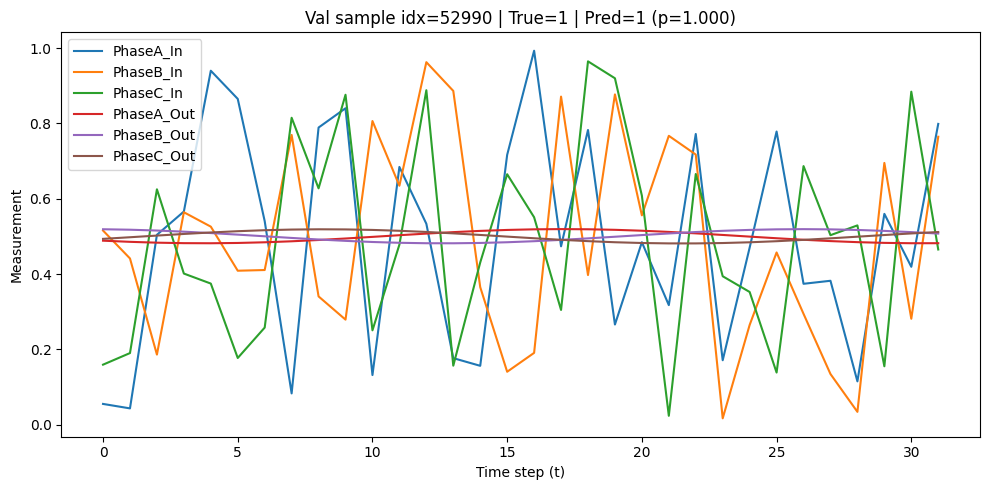

In [23]:
# infer_and_plot_one.py
import os, re, random, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# ---------- Config ----------
MODEL_DIR   = "./distilbert_finetuned_main_from_numeric"
CSV_PATH    = "RelayMeasurementDataset.csv"
SEED_SPLIT  = 42      # same split as training
SEED_PICK   = 123     # random pick from validation
T           = 32
channels = ["PhaseA_In","PhaseB_In","PhaseC_In","PhaseA_Out","PhaseB_Out","PhaseC_Out"]
feature_descriptions = [
    "Transformer Differential Relay's current measurement vector of phase A in transformer input side:",
    "Transformer Differential Relay's current measurement vector of phase B in transformer input side:",
    "Transformer Differential Relay's current measurement vector of phase C in transformer input side:",
    "Transformer Differential Relay's current measurement vector of phase A in transformer output side:",
    "Transformer Differential Relay's current measurement vector of phase B in transformer output side:",
    "Transformer Differential Relay's current measurement vector of phase C in transformer output side:"
]
# ---------------------------

def row_to_text(row_vals, T=32, decimals=2):
    """Match the training text format exactly."""
    assert row_vals.shape[0] == T * 6
    m = row_vals.reshape(T, 6)
    parts = []
    for ch_idx in range(6):
        vec = m[:, ch_idx]
        values_str = " ".join(f"{v:.{decimals}f}" for v in vec)
        parts.append(f"{feature_descriptions[ch_idx]} [{values_str}]")
    return " ".join(parts)

# 1) Load data
df = pd.read_csv(CSV_PATH)
assert 'label' in df.columns, "CSV must contain a 'label' column."
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Identify measurement columns; rename generic feature_i -> semantic t{t}_{channel}
measure_cols = [c for c in df.columns if c != 'label']
expected_names = [f"t{t}_{ch}" for t in range(T) for ch in channels]
if len(measure_cols) == 192 and all(re.fullmatch(r"feature_\d+", c) for c in measure_cols):
    df = df.rename(columns={f"feature_{i}": expected_names[i] for i in range(192)})
    measure_cols = expected_names

# 2) Build text column exactly like training
texts = []
for i in range(len(df)):
    row = df.loc[i, measure_cols].to_numpy(dtype=float)
    texts.append(row_to_text(row, T=T, decimals=2))
df_text = pd.DataFrame({"text": texts, "label": df["label"].astype(int).values})

# 3) Recreate the same split and pick one validation sample
train_df, val_df = train_test_split(
    df_text, test_size=0.2, random_state=SEED_SPLIT, stratify=df_text["label"]
)
random.seed(SEED_PICK)
sample = val_df.sample(n=1, random_state=SEED_PICK).iloc[0]
orig_idx = sample.name  # index back into original df_text/df

# 4) Load tokenizer + model and predict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_DIR)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_DIR).to(device)
model.eval()

inputs = tokenizer(
    sample["text"], return_tensors="pt", truncation=True, padding=True, max_length=512
).to(device)

with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
pred = int(np.argmax(probs))
true_label = int(sample["label"])
pred_prob = float(probs[pred])

# 5) Recover numeric measurements and plot all 6 in one figure
vec = df.loc[orig_idx, measure_cols].to_numpy(dtype=float).reshape(T, 6)
timesteps = np.arange(T)

plt.figure(figsize=(10, 5))
for ch in range(6):
    plt.plot(timesteps, vec[:, ch], label=channels[ch])
plt.xlabel("Time step (t)")
plt.ylabel("Measurement")
plt.title(f"Val sample idx={orig_idx} | True={true_label} | Pred={pred} (p={pred_prob:.3f})")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [24]:
# --- Show one tokenized ATTACK sample (label == 1) with selective truncation ---
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer

# ANSI colors (all bold)
RESET = "\033[0m"
BLUE_BOLD = "\033[1;34m"
RED_BOLD = "\033[1;31m"

# 1) Select source DataFrame
if 'train_df' in globals():
    source_df = train_df.copy()
elif 'df_text' in globals():
    source_df = df_text.copy()
else:
    raise RuntimeError("Neither train_df nor df_text found.")

# 2) Pick an attack-row
attacks = source_df[source_df['label'] == 1]
if attacks.empty and 'df_text' in globals():
    attacks = df_text[df_text['label'] == 1]
if attacks.empty:
    raise RuntimeError("No rows with label==1 found.")

# 3) Sample one
SEED = 42 if 'SEED' not in globals() else SEED
sample_row = attacks.sample(n=1, random_state=SEED).iloc[0]
original_text = sample_row['text']

# Helper function for truncation (text)
def truncate_middle(text, keep_start=500, keep_end=300):
    """Keep more at the start, less at the end, remove big middle chunk."""
    if len(text) <= keep_start + keep_end:
        return text
    return text[:keep_start] + " ... " + text[-keep_end:]

# --- Figure 4: truncated original prompt ---
print("\n--- Figure 4: Truncated Prompt ---\n")
trunc_text = truncate_middle(original_text, keep_start=300, keep_end=200)
colored_text = (
    BLUE_BOLD + trunc_text.replace(" ... ", f"{RED_BOLD} ........ {BLUE_BOLD}") + RESET
)
print(colored_text)

# 4) Tokenizer
MODEL_NAME = globals().get('MODEL_NAME', 'distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# 5) Tokenize
enc = tokenizer(
    original_text,
    truncation=True,
    padding="max_length",
    max_length=512,  # DistilBERT limit
    return_attention_mask=True,
    return_tensors=None
)

input_ids = enc["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Helper for truncating tokens
def truncate_tokens(tokens, keep_start=70, keep_end=50):
    """Keep most tokens, remove a smaller chunk in the middle."""
    if len(tokens) <= keep_start + keep_end:
        return tokens
    return tokens[:keep_start] + ["..."] + tokens[-keep_end:]

# --- Figure 5: truncated token list (quoted, bold blue tokens, bold red ellipsis) ---
print("\n--- Figure 5: Truncated Tokens ---\n")
trunc_tokens = truncate_tokens(tokens, keep_start=300, keep_end=200)

for tok in trunc_tokens:
    if tok == "...":
        print(f'{RED_BOLD} ........ {RESET}', end=" ")
    else:
        print(f'{BLUE_BOLD}"{tok}"{RESET}', end=" ")
print()



--- Figure 4: Truncated Prompt ---

Transformer Differential Relay's current measurement vector of phase A in transformer input side: [0.45 0.48 0.50 0.53 0.55 0.57 0.59 0.60 0.61 0.61 0.60 0.59 0.57 0.56 0.53 0.51 0.47 0.44 0.39 0.34 0.28 0.22 0.16 0.10 0.06 0.02 0.01 0.00 0.02 0.05 0.09 0.14] Transformer Differential Relay's current ........ of phase C in transformer output side: [0.48 0.49 0.49 0.50 0.50 0.50 0.51 0.51 0.52 0.52 0.52 0.52 0.52 0.52 0.51 0.51 0.46 0.46 0.47 0.49 0.53 0.48 0.54 0.61 0.68 0.77 0.76 0.81 0.88 0.92 0.97 0.92]

--- Figure 5: Truncated Tokens ---

"[CLS]" "transform" "##er" "differential" "relay" "'" "s" "current" "measurement" "vector" "of" "phase" "a" "in" "transform" "##er" "input" "side" ":" "[" "0" "." "45" "0" "." "48" "0" "." "50" "0" "." "53" "0" "." "55" "0" "." "57" "0" "." "59" "0" "." "60" "0" "." "61" "0" "." "61" "0" "." "60" "0" "." "59" "0" "." "57" "0" "." "56" "0" "." "53" "0" "." "51" "0" "." "47" "0" "." "44" "0" "." "39" "0" "." "34" 